# UTKFace Age, gender and ethnicity prediction model

UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc. Some sample images are shown as following

The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 324M/331M [00:02<00:00, 175MB/s]
100% 331M/331M [00:02<00:00, 164MB/s]


In [ ]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content')
zip.close()

In [ ]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [ ]:
dataset_folder_name = '/content/utkface_aligned_cropped/UTKFace'

In [ ]:
dataset_dict = {
    'ethnicity_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['ethnicity_alias'] = dict((r, i) for i, r in dataset_dict['ethnicity_id'].items())

In [ ]:
dataset_dict

{'ethnicity_id': {0: 'white',
  1: 'black',
  2: 'asian',
  3: 'indian',
  4: 'others'},
 'gender_id': {0: 'male', 1: 'female'},
 'gender_alias': {'male': 0, 'female': 1},
 'ethnicity_alias': {'white': 0,
  'black': 1,
  'asian': 2,
  'indian': 3,
  'others': 4}}

In [ ]:
def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')            
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['ethnicity_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
def parse_dataset(dataset_path, ext='jpg'):     
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file_path'] = files
    df.columns = ['age', 'gender', 'ethnicity', 'file_path']
    df = df.dropna()
    
    return df

In [ ]:
df = parse_dataset(dataset_folder_name)
df['file_name'] = ''
df['file_name'] = df.apply(lambda x : x['file_path'].split('/')[-1], axis = 1)
df.head()

,age,gender,ethnicity,file_path,file_name
0,45.0,male,white,/content/utkface_aligned_cropped/UTKFace/45_0_...,45_0_0_20170116205749382.jpg.chip.jpg
1,10.0,female,white,/content/utkface_aligned_cropped/UTKFace/10_1_...,10_1_0_20170109204931156.jpg.chip.jpg
2,58.0,male,white,/content/utkface_aligned_cropped/UTKFace/58_0_...,58_0_0_20170105173559373.jpg.chip.jpg
3,30.0,male,white,/content/utkface_aligned_cropped/UTKFace/30_0_...,30_0_0_20170116221857954.jpg.chip.jpg
4,44.0,male,white,/content/utkface_aligned_cropped/UTKFace/44_0_...,44_0_0_20170105172858549.jpg.chip.jpg


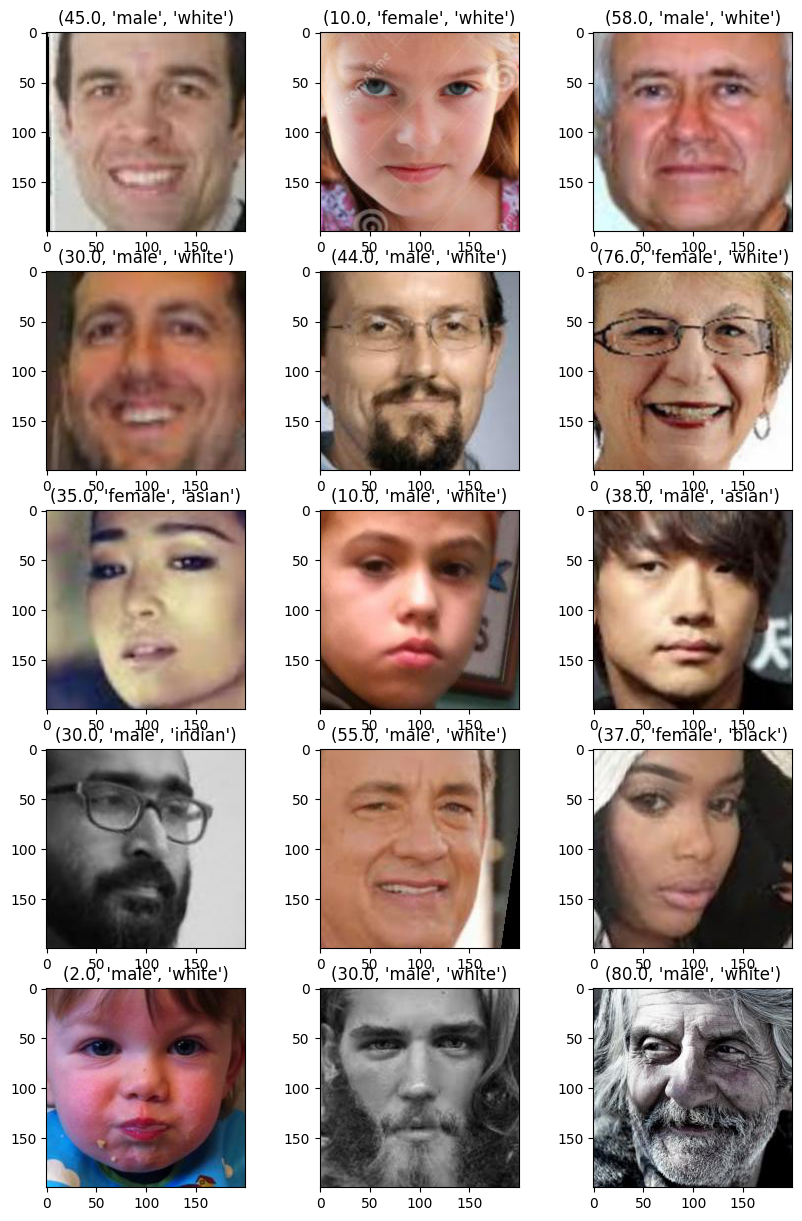

In [ ]:
plt.figure(figsize=(10,15))

for i in range(15):
    plt.subplot(5,3,i+1)
    file = df['file_path'][i]
    image = imread(file)
    plt.imshow(image)
    plt.title((df['age'][i], df['gender'][i], df['ethnicity'][i]))

In [ ]:
df['gender'] = df.apply(lambda x : dataset_dict['gender_alias'][x['gender']], axis = 1)
df['ethnicity'] = df.apply(lambda x : dataset_dict['ethnicity_alias'][x['ethnicity']], axis = 1)
df.head()

,age,gender,ethnicity,file_path,file_name
0,45.0,0,0,/content/utkface_aligned_cropped/UTKFace/45_0_...,45_0_0_20170116205749382.jpg.chip.jpg
1,10.0,1,0,/content/utkface_aligned_cropped/UTKFace/10_1_...,10_1_0_20170109204931156.jpg.chip.jpg
2,58.0,0,0,/content/utkface_aligned_cropped/UTKFace/58_0_...,58_0_0_20170105173559373.jpg.chip.jpg
3,30.0,0,0,/content/utkface_aligned_cropped/UTKFace/30_0_...,30_0_0_20170116221857954.jpg.chip.jpg
4,44.0,0,0,/content/utkface_aligned_cropped/UTKFace/44_0_...,44_0_0_20170105172858549.jpg.chip.jpg


In [ ]:
# split the data into train and test 
train_df = df.sample(frac=1, random_state=0).iloc[:20000]
test_df = df.sample(frac=1, random_state=0).iloc[20000:]
# x_train = df.iloc[:,0:20000]
# x_test = df.iloc[:,20000:]

In [ ]:
train_df.shape, test_df.shape

((20000, 5), (3705, 5))

In [ ]:
# Data Augmentation required
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    )

test_datagen = ImageDataGenerator(rescale =1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train_df, directory=dataset_folder_name, 
                                                    x_col = 'file_name', y_col=['age','gender','ethnicity'],
                                                    target_size=(200,200),
                                                    class_mode = 'multi_output')

test_generator = test_datagen.flow_from_dataframe(test_df, directory=dataset_folder_name, 
                                                    x_col = 'file_name', y_col=['age','gender','ethnicity'],
                                                    target_size=(200,200),
                                                    class_mode = 'multi_output')

Found 20000 validated image filenames.
Found 3705 validated image filenames.


# Transfer Learning - VGG16

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model 
from keras.models import Sequential 

In [ ]:
vgg16_model = VGG16(include_top=False, input_shape=(200,200,3))
vgg16_model.trainable = False

output = vgg16_model.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)
dense3 = Dense(512, activation='relu')(flatten)

dense4 = Dense(256, activation='relu')(dense1)
dense5 = Dense(512, activation='relu')(dense2)
dense6 = Dense(512, activation='relu')(dense3)
dense7 = Dense(256, activation='relu')(dense6)
dense8 = Dense(128, activation='relu')(dense7)
dense9 = Dense(64, activation='relu')(dense8)
dense10 = Dense(32, activation='relu')(dense9)

output1 = Dense(1, activation='linear', name='age')(dense4)
output2 = Dense(1, activation='sigmoid', name='gender')(dense5)
output3 = Dense(1, activation='softmax', name='ethnicity')(dense10)

In [ ]:
model = Model(inputs=vgg16_model.input, outputs=[output1, output2, output3])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 200, 200, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 200, 200, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

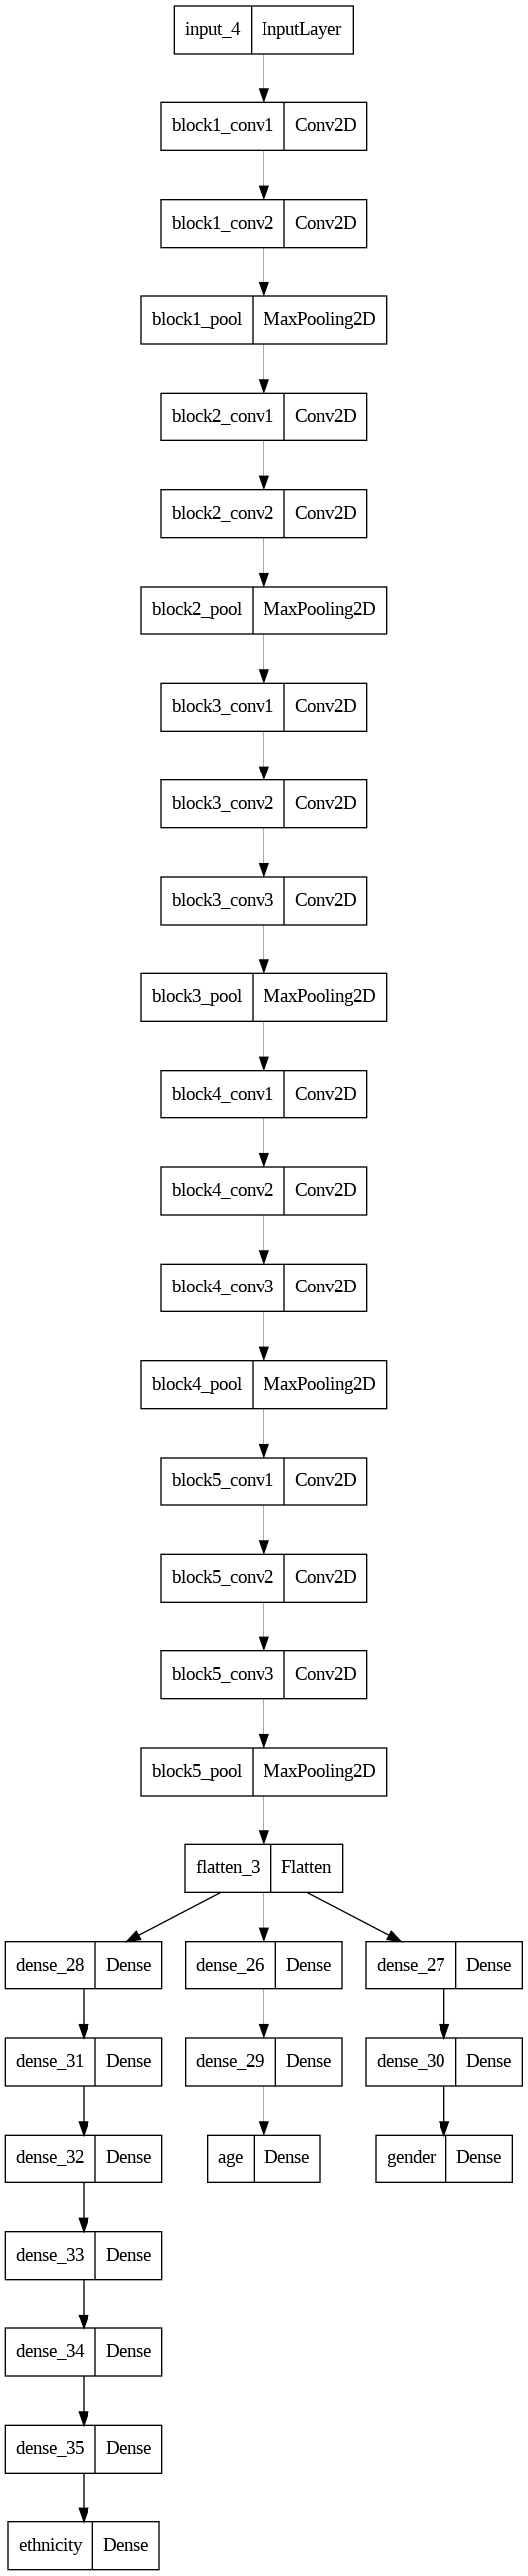

In [ ]:
model.summary()
from keras.utils import plot_model 
plot_model(model)

In [ ]:
model.compile(optimizer='adam', loss={'age':'mae',"gender":'binary_crossentropy','ethnicity':'sparse_categorical_crossentropy'},
              metrics={'age':'mse', 'gender':'accuracy', 'ethnicity':'accuracy'})

In [ ]:
model.fit(train_generator, batch_size=512, epochs=10, validation_data=test_generator)

Epoch 1/10
554/625 [=========================>....] - ETA: 25s - loss: nan - age_loss: 9.4658 - gender_loss: 0.4490 - ethnicity_loss: nan - age_mse: 171.9243 - gender_accuracy: 0.7827 - ethnicity_accuracy: 0.4255

KeyboardInterrupt: ignored

In [ ]:
SPLIT = 0.2

from sklearn.model_selection import train_test_split

training_data, validation_data = train_test_split(df, test_size=SPLIT)

n_train = len(training_data)
n_val = len(validation_data)

print('No. of training image:', n_train)
print('No. of validation image:', n_val)

No. of training image: 18964
No. of validation image: 4741


In [ ]:
HEIGHT = WIDTH = 128

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 64

train_generator = train_datagen.flow_from_dataframe(training_data, 
                                                    directory=dataset_folder_name, 
                                                    x_col = 'file_name', 
                                                    y_col = ['age', 'gender', 'ethnicity'], 
                                                    target_size = (HEIGHT, WIDTH),
                                                    class_mode = 'multi_output',
                                                    batch_size = BATCH_SIZE,
                                                    seed = 37)

val_generator = val_datagen.flow_from_dataframe(validation_data, 
                                                directory=dataset_folder_name, 
                                                x_col = 'file_name', 
                                                y_col = ['age', 'gender', 'ethnicity'], 
                                                target_size = (HEIGHT, WIDTH),
                                                class_mode = 'multi_output',
                                                batch_size = BATCH_SIZE,
                                                seed = 37)

Found 18964 validated image filenames.
Found 4741 validated image filenames.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf

class MTL_UTK():
    def make_default_hidden_layers(self, inputs):
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)        
        return x  
    
    def build_ethnicity_branch(self, inputs, num_ethnicities):
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_ethnicities)(x)
        x = Activation("softmax", name="ethnicity_output")(x)        
        return x  
    
    def build_gender_branch(self, inputs, num_genders=1): 
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)       
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)        
        return x  
    
    def build_age_branch(self, inputs):            
        x = self.make_default_hidden_layers(inputs)        
        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(1)(x)
        x = Activation("linear", name="age_output")(x)        
        return x 
    
    def assemble_full_model(self, height, width, num_ethnicities):       
        input_shape = (height, width, 3)        
        inputs = Input(shape=input_shape)        
        age_branch = self.build_age_branch(inputs)
        gender_branch = self.build_gender_branch(inputs)
        ethnicity_branch = self.build_ethnicity_branch(inputs, num_ethnicities)        
        model = Model(inputs=inputs,
                     outputs = [age_branch, gender_branch, ethnicity_branch],
                     name="face_net")        
        return model

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 128, 128, 16  448         ['input_2[0][0]']                
                                )                                                          

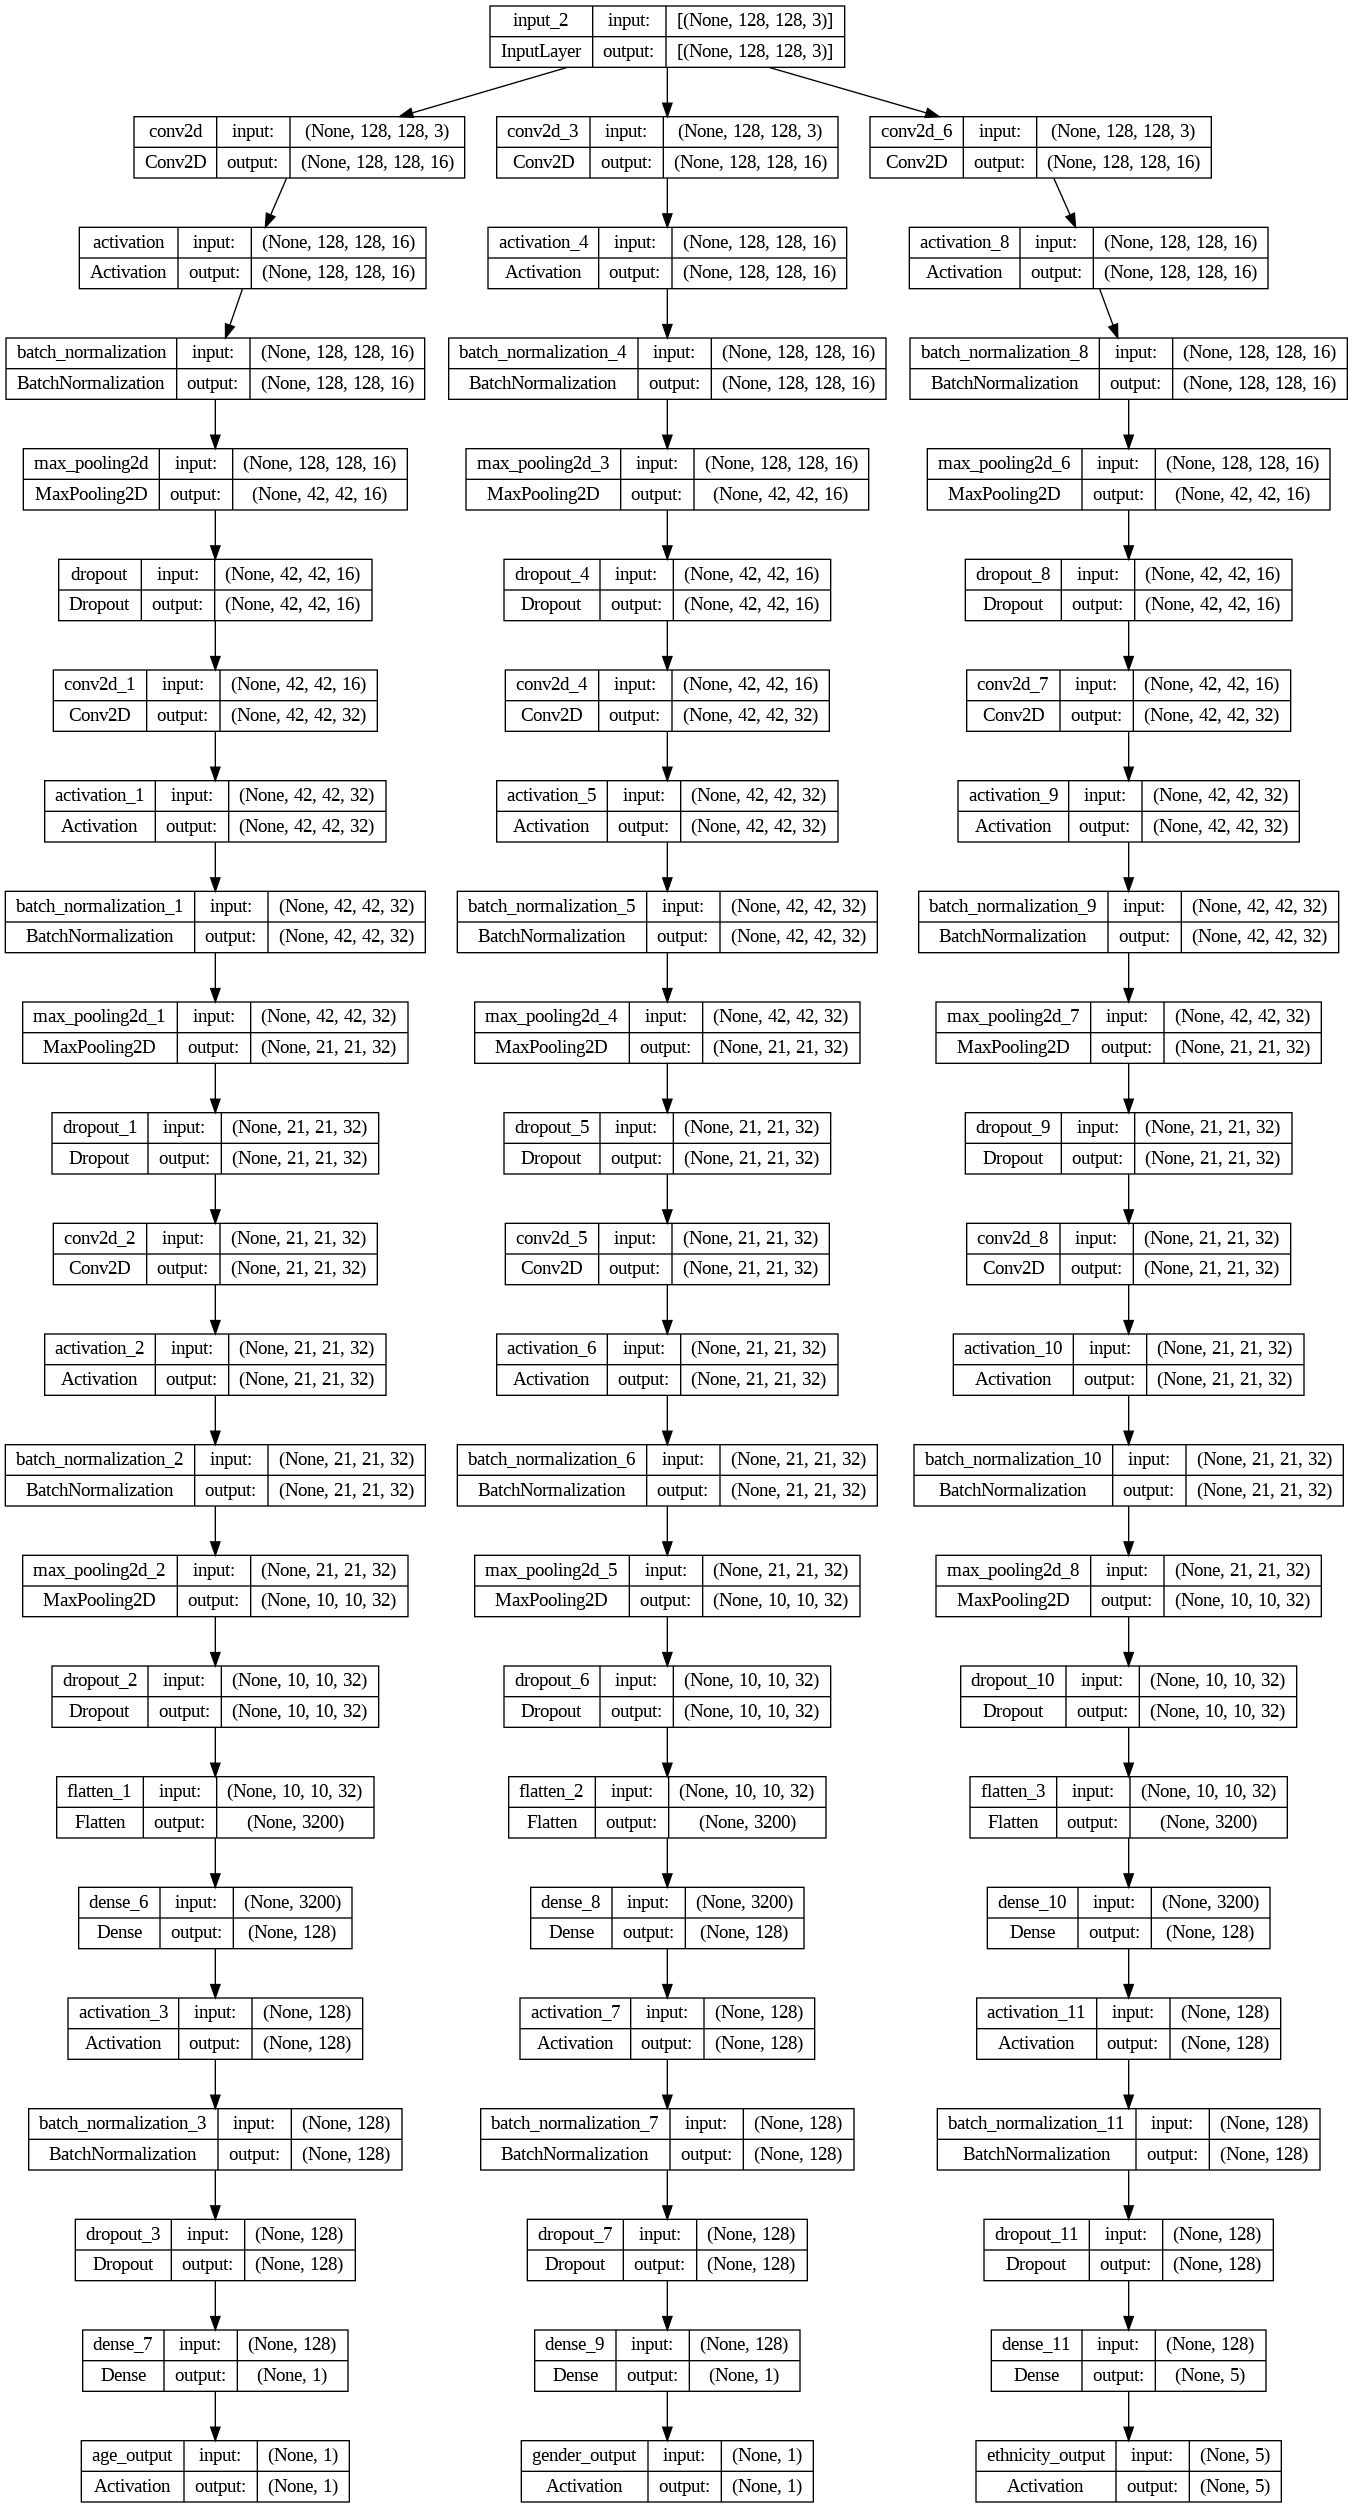

In [ ]:
model = MTL_UTK().assemble_full_model(HEIGHT, WIDTH, num_ethnicities=len(dataset_dict['ethnicity_alias']))

model.summary()

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
init_lr = 1e-4
epochs = 50

In [ ]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=init_lr)
model.compile(optimizer=opt, 
              loss={
                  'age_output': 'mse',
                  'gender_output': 'binary_crossentropy',
                  'ethnicity_output': 'sparse_categorical_crossentropy'},
              
              loss_weights={
                  'age_output': 4., 
                  'gender_output': 0.1,
                  'ethnicity_output': 1.5},
              
              metrics={
                  'age_output': 'mae', 
                  'gender_output': 'accuracy',
                  'ethnicity_output': 'accuracy'})

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# earlystopping = EarlyStopping(monitor ="val_loss", 
#                                         mode ="min", patience = 5, 
#                                         restore_best_weights = True)

checkpoint = ModelCheckpoint("Best_model_params.h5", monitor='val_loss')

# callbacks = [checkpoint, earlystopping]
callbacks = [checkpoint]

history = model.fit(train_generator,
                    steps_per_epoch = n_train // BATCH_SIZE, 
                    epochs=epochs,
                    batch_size = BATCH_SIZE,
                    validation_data=val_generator,
                    validation_steps = n_val // BATCH_SIZE,
                    callbacks = callbacks)

Epoch 1/50
296/296 [==============================] - 53s 141ms/step - loss: 5683.5601 - age_output_loss: 1420.1266 - gender_output_loss: 0.7072 - ethnicity_output_loss: 1.9886 - age_output_mae: 32.9573 - gender_output_accuracy: 0.6797 - ethnicity_output_accuracy: 0.3698 - val_loss: 5890.5439 - val_age_output_loss: 1471.9271 - val_gender_output_loss: 0.8988 - val_ethnicity_output_loss: 1.8296 - val_age_output_mae: 33.3619 - val_gender_output_accuracy: 0.4728 - val_ethnicity_output_accuracy: 0.4297
Epoch 2/50
296/296 [==============================] - 40s 134ms/step - loss: 5192.1509 - age_output_loss: 1297.4401 - gender_output_loss: 0.5619 - ethnicity_output_loss: 1.5560 - age_output_mae: 32.4372 - gender_output_accuracy: 0.7536 - ethnicity_output_accuracy: 0.4745 - val_loss: 5882.4336 - val_age_output_loss: 1470.0612 - val_gender_output_loss: 0.4550 - val_ethnicity_output_loss: 1.4295 - val_age_output_mae: 34.8225 - val_gender_output_accuracy: 0.7842 - val_ethnicity_output_accuracy: 0

Text(0.5, 0, 'epoch')

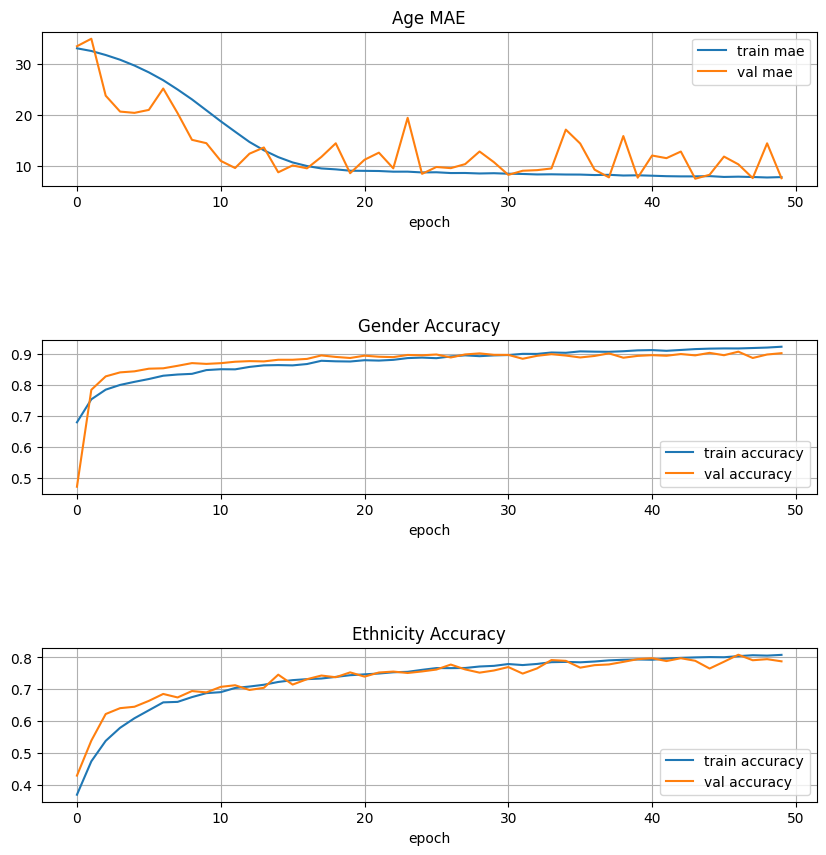

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

fig.add_subplot(3,1,1)
plt.plot(history.history['age_output_mae'], label='train mae')
plt.plot(history.history['val_age_output_mae'], label='val mae')
plt.title('Age MAE')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,1,2)
plt.plot(history.history['gender_output_accuracy'], label='train accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='val accuracy')
plt.title('Gender Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

fig.add_subplot(3,1,3)
plt.plot(history.history['ethnicity_output_accuracy'], label='train accuracy')
plt.plot(history.history['val_ethnicity_output_accuracy'], label='val accuracy')
plt.title('Ethnicity Accuracy')
plt.legend()
plt.grid(True)
plt.xlabel('epoch')

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread('/content/WhatsApp Image 2023-04-28 at 7.51.20 PM.jpeg')

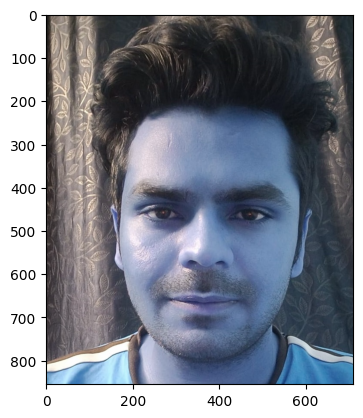

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(855, 711, 3)

In [ ]:
test_img = cv2.resize(test_img, (200,200))

In [ ]:
test_img.shape

(200, 200, 3)

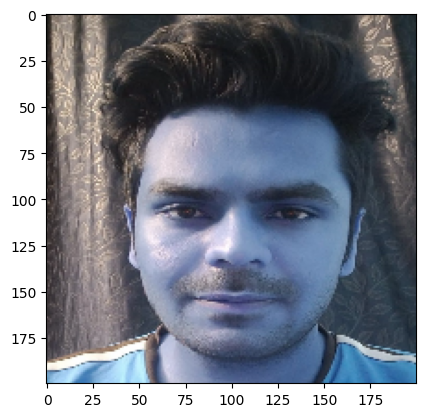

In [ ]:
plt.imshow(test_img)

In [ ]:
test_input = test_img.reshape((1,200,200,3))

In [ ]:
model.predict(test_input)

1/1 [==============================] - 1s 806ms/step


[array([[153.12048]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32)]